In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
# Load measurement file:
measurement = np.load('dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']

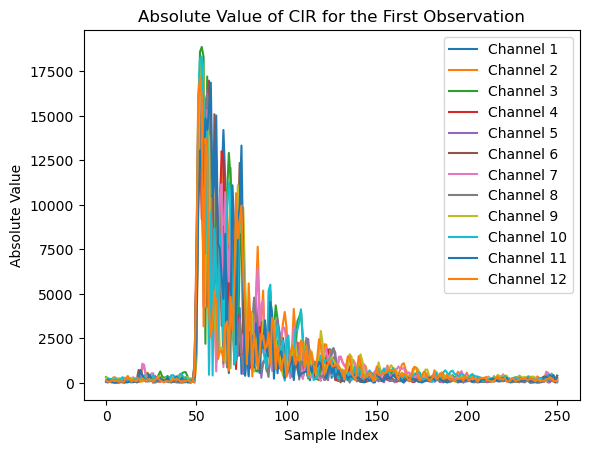

In [2]:
# ---------------- Task 1: first observation plot ----------------

cir_to_plot = data['cirs'][0]  # Select the first observation

# Calculate the absolute value (magnitude) across the last dimension (axis=2)
abs_cir = np.abs(cir_to_plot[:,:,0] + 1j*cir_to_plot[:,:,1]) # 1j*imaginary part where 1j is the imaginary unit

# no of channels
no_of_channel= 12

# Plot the absolute value of the CIR
for i in range(no_of_channel): 
    plt.plot(abs_cir[i], label=f'Channel {i+1}')


plt.xlabel('Sample Index')
plt.ylabel('Absolute Value')
plt.title('Absolute Value of CIR for the First Observation')
plt.legend()
plt.show()

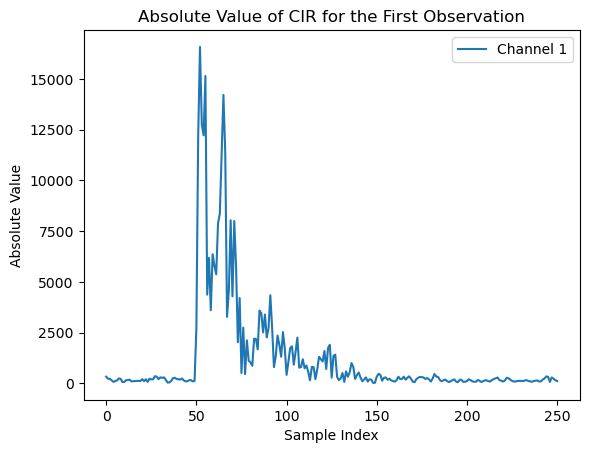

In [3]:
# ---------------- Task 2: A single channel signal plot ----------------

cir_to_plot = data['cirs'][0]  # Select the first observation

# Calculate the absolute value (magnitude) across the last dimension (axis=2)
abs_cir = np.abs(cir_to_plot[:,:,0] + 1j*cir_to_plot[:,:,1]) # 1j*imaginary part where 1j is the imaginary unit

# no of channels
no_of_channel= 12

# Plot the absolute value of the CIR
for i in range(no_of_channel): 
    plt.plot(abs_cir[i], label=f'Channel {i+1}')
    if i == 0:
        break


plt.xlabel('Sample Index')
plt.ylabel('Absolute Value')
plt.title('Absolute Value of CIR for the First Observation')
plt.legend()
plt.show()

In [ ]:
# ------------------------------------------------- sparse_mag_svm_omp_long.ipynb -------------------------------------------------
# Library
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import DictionaryLearning, sparse_encode
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)

# Load data
measurement = np.load('../test/dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
data_cir = data['cirs'][:1000]  # Using 1000 samples for simplicity

# Split data
trainCIR, testCIR = train_test_split(data_cir, test_size=0.2, random_state=42)
print(f"Training data: {trainCIR.shape}")
# Define channels
alice_channel = 3  # Channel 3 is ALICE (legitimate)
eve_channel = 6    # Channel 6 is EVE (illegitimate)

# Set the number of dictionary atoms (components) and sparsity level
# N_components = 3  # Number of Sparse Components
n_components = 4  # Try values like 20, 50, or 100
n_nonzero_coefs = 3 # Sparsity level
no_train_cirs = trainCIR.shape[0]
no_test_cirs = testCIR.shape[0]


# ----------------------------------------------------- Preprocessing -----------------------------------------------------
# ----------------- Training data -----------------
train_alice_cirs = trainCIR[:, alice_channel, :, :]  # Alice's CIRs
train_eve_cirs = trainCIR[:, eve_channel, :, :]      # Eve's CIRs
train_alice_magnitude = np.abs(train_alice_cirs[..., 0] + 1j * train_alice_cirs[..., 1])
train_eve_magnitude = np.abs(train_eve_cirs[..., 0] + 1j * train_eve_cirs[..., 1])
train_data_combined  = np.vstack((train_alice_magnitude, train_eve_magnitude))

# Learn the dictionary
dl_alice = DictionaryLearning(n_components=n_components, transform_algorithm='lasso_lars', n_jobs= -1)
dl_eve = DictionaryLearning(n_components=n_components, transform_algorithm='lasso_lars', n_jobs= -1)

dl_alice.fit(train_alice_magnitude)
dictionary_alice = dl_alice.components_

dl_eve.fit(train_eve_magnitude)
dictionary_eve = dl_eve.components_


# Create an OMP object
omp_alice = OrthogonalMatchingPursuit(n_nonzero_coefs = 3)  # adjust the number of non-zero coefficients as needed
omp_eve = OrthogonalMatchingPursuit(n_nonzero_coefs = 3)  # adjust the number of non-zero

sparse_rep_alice = np.zeros((no_train_cirs, n_components))
sparse_rep_eve = np.zeros((no_train_cirs, n_components))

for i in range(no_train_cirs):
    # For Alice
    omp_alice.fit(dictionary_alice.T, train_alice_magnitude[i]) 
    sparse_rep_alice[i] = omp_alice.coef_

    # For Eve
    omp_eve.fit(dictionary_eve.T, train_eve_magnitude[i]) 
    sparse_rep_eve[i] = omp_eve.coef_
    
print(sparse_rep_alice[0])


test_alice_CIRs = testCIR[:, alice_channel, :, :]
test_eve_CIRs = testCIR[:, eve_channel, :, :]

# test amplitude
test_alice_magnitude = np.abs(test_alice_CIRs[..., 0] + 1j * test_alice_CIRs[..., 1])
test_eve_magnitude = np.abs(test_eve_CIRs[..., 0] + 1j * test_eve_CIRs[..., 1]) 
test_cirs = np.vstack((test_alice_magnitude, test_eve_magnitude))

dl_test_alice = DictionaryLearning(n_components=n_components, transform_algorithm='lasso_lars', n_jobs= -1)
dl_test_eve = DictionaryLearning(n_components=n_components, transform_algorithm='lasso_lars', n_jobs= -1)

dl_test_alice.fit(test_alice_magnitude)
dictionary_test_alice = dl_alice.components_

dl_test_eve.fit(test_eve_magnitude)
dictionary_test_eve = dl_eve.components_

# Create an OMP object
omp_test_alice = OrthogonalMatchingPursuit(n_nonzero_coefs = 3)  # adjust the number of non-zero coefficients as needed
omp_test_eve = OrthogonalMatchingPursuit(n_nonzero_coefs = 3)

sparse_rep_test_alice = np.zeros((no_test_cirs, n_components))
sparse_rep_test_eve = np.zeros((no_test_cirs, n_components))

for i in range(no_test_cirs):
    # For test_Alice
    omp_test_alice.fit(dictionary_test_alice.T, test_alice_magnitude[i]) 
    sparse_rep_test_alice[i] = omp_test_alice.coef_

    # For test_Eve
    omp_test_eve.fit(dictionary_test_eve.T, test_eve_magnitude[i]) 
    sparse_rep_test_eve[i] = omp_test_eve.coef_
    
print(sparse_rep_test_alice[0])


print(f"Training data: {sparse_rep_alice.shape}")

train_sparse_data = np.vstack((sparse_rep_alice, sparse_rep_eve))
test_sparse_data = np.vstack((sparse_rep_test_alice, sparse_rep_test_eve))

# Labels for training data
train_alice_labels = np.zeros(sparse_rep_alice.shape[0])  # Label '0' for Alice.
train_eve_labels = np.ones(sparse_rep_eve.shape[0])       # Label '1' for Eve.
train_labels = np.hstack((train_alice_labels, train_eve_labels))

# Labels for test data
test_alice_labels = np.zeros(sparse_rep_test_alice.shape[0])  # Label '0' for Alice.
test_eve_labels = np.ones(sparse_rep_test_eve.shape[0])       # Label '1' for Eve.
test_labels = np.hstack((test_alice_labels, test_eve_labels))


scaler = StandardScaler()
train_sparse_codes = scaler.fit_transform(train_sparse_data)
# Apply the same scaling to test data
test_sparse_codes = scaler.transform(test_sparse_data)
print('Train data shape:', train_sparse_codes.shape)



# Initialize and train the SVM classifier
classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(train_sparse_codes, train_labels)

# Predict on test data
predictions = classifier.predict(test_sparse_codes)


from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, predictions, labels=[0, 1]).ravel()

print(f"tp: {tp}")
print(f"tn: {tn}")
print(f"fp: {fp}")
print(f"fn: {fn}")

# Calculate MDR, FAR, AR
MDR = fp / (fp + tn) if (fp + tn) > 0 else 0
FAR = fn / (fn + tp) if (fn + tp) > 0 else 0
gamma = (tp + fn) / (tn + fp) if (tn + fp) > 0 else 0
AR = (tp + gamma * tn) / ((tp + fn) + gamma * (tn + fp)) if ((tp + fn) + gamma * (tn + fp)) > 0 else 0

print(f"MDR: {MDR}")
print(f"FAR: {FAR}")
print(f"AR: {AR}")


In [ ]:
# ------------------------------------------------- sparse_amp_residual.ipynb -------------------------------------------------
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)

no_nonzero_coefs = 100

measurement = np.load('../test/dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
data_cir = data['cirs'][:1000]
trainCIR, testCIR = train_test_split(data_cir, test_size=0.2, random_state=42)
print(trainCIR.shape, testCIR.shape)

# Define channels
alice_channel = 3  # Channel 3 is ALICE (legitimate)
eve_channel = 6  # Channel 6 is EVE (illegitimate)

train_alice_cirs = trainCIR[:, alice_channel, :, :]  # Alice's CIRs
train_eve_cirs = trainCIR[:, eve_channel, :, :]      # Eve's CIRs
train_alice_magnitude = np.abs(train_alice_cirs[..., 0] + 1j * train_alice_cirs[..., 1])
train_eve_magnitude = np.abs(train_eve_cirs[..., 0] + 1j * train_eve_cirs[..., 1])
train_data_combined  = np.vstack((train_alice_magnitude, train_eve_magnitude))

# Create labels for Alice and Eve for training
alice_train_labels = np.zeros(train_alice_magnitude.shape[0])  # Label '0' for Alice.
eve_train_labels = np.ones(train_eve_magnitude.shape[0])       # Label '1' for Eve.

# Combine data and labels for training
train_atoms = train_data_combined
train_labels = np.hstack((alice_train_labels, eve_train_labels))
print(train_atoms.shape)
# Step 4: Form the Dictionary D from Training Data
D = train_atoms.T


# # Step 3: Extract Features for Test Data
test_alice_CIRs = testCIR[:, alice_channel, :, :]
test_eve_CIRs = testCIR[:, eve_channel, :, :]
# test amplitude
test_alice_magnitude = np.abs(test_alice_CIRs[..., 0] + 1j * test_alice_CIRs[..., 1])
test_eve_magnitude = np.abs(test_eve_CIRs[..., 0] + 1j * test_eve_CIRs[..., 1]) 
test_cirs = np.vstack((test_alice_magnitude, test_eve_magnitude))

# Create labels for Alice and Eve for testing
alice_test_labels = np.zeros(test_alice_magnitude.shape[0])  # Label '0' for Alice.
eve_test_labels = np.ones(test_eve_magnitude.shape[0])       # Label '1' for Eve.

# Combine data and labels for testing
test_atoms = np.vstack((test_alice_magnitude, test_eve_magnitude))
test_labels = np.hstack((alice_test_labels, eve_test_labels))


# Step 5: Sparse Coding Function
def find_sparse_coefficients(tSample, D, n_nonzero_coefs=no_nonzero_coefs):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
    omp.fit(D, tSample)
    return omp.coef_

# Step 6: Function to Calculate Residuals for Each Class
def calculate_residual(tSample, coefficients, class_indices, D):
    coef_class = np.zeros_like(coefficients)
    coef_class[class_indices] = coefficients[class_indices]  # Keep onltSample coefficients for the specified class
    reconstructed_signal = D @ coef_class
    residual = np.linalg.norm(tSample - reconstructed_signal)
    return residual

# Step 7: Classification Function
def classify_signal(tSample, D, trainLabel):
    
    coefficients = find_sparse_coefficients(tSample, D)
    
    residuals = []

    unique_classes = np.unique(trainLabel) # 0 and 1
    for class_label in unique_classes:
        class_indices = np.where(trainLabel == class_label)[0]  # Indices of columns in D belonging to this class
        residual = calculate_residual(tSample, coefficients, class_indices, D)
        residuals.append(residual)

    # Predict the class with the smallest residual
    predicted_class = unique_classes[np.argmin(residuals)]
    return predicted_class


# Step 8: Classifying Test Data and Evaluating the Model
predictions = []

for testSample in test_atoms:
    predicted_class = classify_signal(testSample, D, train_labels)
    predictions.append(predicted_class)


predictions = np.array(predictions)
# print(predictions.shape)


accuracy = np.mean(predictions == test_labels)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# --------------------------------------------- sparse_mag_svm.ipynb ---------------------------------------------------------
# Library
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import DictionaryLearning, sparse_encode
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)

# Load data
measurement = np.load('../test/dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
data_cir = data['cirs'][:1000]  # Using 1000 samples for simplicity

# Split data
# First, split into train (60%) and temp (40%) sets
trainCIR, tempCIR = train_test_split(data_cir, test_size=0.4, random_state=42)

# Now, split tempCIR into test (20%) and evaluation (20%) sets
testCIR, evalCIR = train_test_split(tempCIR, test_size=0.5, random_state=42)

print(f"Train Data: {trainCIR.shape}")
print(f"Test Data: {testCIR.shape}")
print(f"Evaluation Data: {evalCIR.shape}")


# Define channels
alice_channel = 3  # Channel 3 is ALICE (legitimate)
eve_channel = 6    # Channel 6 is EVE (illegitimate)

# Set the number of dictionary atoms (components) and sparsity level
# N_components = 3  # Number of Sparse Components
n_components = 3  # Try values like 20, 50, or 100
n_nonzero_coefs = 3 # Sparsity level


# ----------------------------------------------------- Preprocessing -----------------------------------------------------
# ----------------- Training data -----------------
train_alice_cirs = trainCIR[:, alice_channel, :, :]  # Alice's CIRs
train_eve_cirs = trainCIR[:, eve_channel, :, :]      # Eve's CIRs
train_alice_magnitude = np.abs(train_alice_cirs[..., 0] + 1j * train_alice_cirs[..., 1])
train_eve_magnitude = np.abs(train_eve_cirs[..., 0] + 1j * train_eve_cirs[..., 1])
train_data_combined  = np.vstack((train_alice_magnitude, train_eve_magnitude))

# Learn the dictionary
dl_alice = DictionaryLearning(n_components=n_components, transform_algorithm='omp', transform_n_nonzero_coefs=n_nonzero_coefs, n_jobs= -1)
dl_eve = DictionaryLearning(n_components=n_components, transform_algorithm='omp', transform_n_nonzero_coefs=n_nonzero_coefs,  n_jobs= -1)
dl_alice.fit(train_alice_magnitude)
dl_eve.fit(train_eve_magnitude)
# dict_learner.fit(train_data_combined)


train_alice_sparse_codes = dl_alice.transform(train_alice_magnitude)
train_eve_sparse_codes = dl_eve.transform(train_eve_magnitude)
train_sparse_codes = np.vstack((train_alice_sparse_codes, train_eve_sparse_codes))
print(train_alice_sparse_codes.shape)
print(train_alice_sparse_codes[0])



test_alice_CIRs = testCIR[:, alice_channel, :, :]
test_eve_CIRs = testCIR[:, eve_channel, :, :]

# test amplitude
test_alice_magnitude = np.abs(test_alice_CIRs[..., 0] + 1j * test_alice_CIRs[..., 1])
test_eve_magnitude = np.abs(test_eve_CIRs[..., 0] + 1j * test_eve_CIRs[..., 1]) 
test_cirs = np.vstack((test_alice_magnitude, test_eve_magnitude))


# Transform test data into sparse codes
# test_alice_sparse_codes = dict_learner.transform(test_alice_magnitude)
# test_eve_sparse_codes = dict_learner.transform(test_eve_magnitude)

test_alice_sparse_codes = dl_alice.transform(test_alice_magnitude)
test_eve_sparse_codes = dl_eve.transform(test_eve_magnitude)

# Combine the sparse codes
test_sparse_codes = np.vstack((test_alice_sparse_codes, test_eve_sparse_codes))
print('Test data shape:', test_sparse_codes.shape)


# Labels for training data
train_alice_labels = np.zeros(train_alice_sparse_codes.shape[0])  # Label '0' for Alice.
train_eve_labels = np.ones(train_eve_sparse_codes.shape[0])       # Label '1' for Eve.
train_labels = np.hstack((train_alice_labels, train_eve_labels))

# Labels for test data
test_alice_labels = np.zeros(test_alice_sparse_codes.shape[0])  # Label '0' for Alice.
test_eve_labels = np.ones(test_eve_sparse_codes.shape[0])       # Label '1' for Eve.
test_labels = np.hstack((test_alice_labels, test_eve_labels))


scaler = StandardScaler()
train_sparse_codes = scaler.fit_transform(train_sparse_codes)
# Apply the same scaling to test data
test_sparse_codes = scaler.transform(test_sparse_codes)
print('Train data shape:', train_sparse_codes.shape)

# Initialize and train the SVM classifier
classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(train_sparse_codes, train_labels)

# Predict on test data
predictions = classifier.predict(test_sparse_codes)






In [ ]:
# ------------------------------------------ ALPLA ------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)


# Load dataset
measurement = np.load('../../../dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
data_cir = data['cirs'][:1000]

# Train-test split
trainCIR, testCIR = train_test_split(data_cir, test_size=0.2, random_state=42)
print(f'trainData - {trainCIR.shape}')
print(f'testData - {testCIR.shape}')

# Define channels
alice_channel = 3  # A -> B (legitimate)
eve_channel = 6  # E -> B (illegitimate)

window_size = 100  # Define a fixed window size


def cirto64Samples(cirs):
    print(f'Input data shape: {cirs.shape}')
    real = cirs[:, :, 0]
    imag = cirs[:, :, 1]
    
    # Number of signals
    num_signals = real.shape[0]  # 3 in this case
    
    # Initialize lists to store the focused samples
    imp_real_parts = []
    imp_imag_parts = []
    img_mag_parts = []
    
    for i in range(num_signals):
        # Calculate the magnitude
        magnitude = np.abs(real[i] + 1j * imag[i])
        
        # find the peak index
        peak_index = np.argmax(magnitude)
        
        # Calculate the start and end indices for the focused part
        start_index = max(0, peak_index - 32)
        end_index = min(magnitude.shape[0], peak_index + 32)
        
        # Extract the part of the signal around the peak
        real_part_focus = real[i, start_index:end_index]
        imag_part_focus = imag[i, start_index:end_index]
        mag_part_focus = magnitude[start_index:end_index]
        
        imp_real_parts.append(real_part_focus)
        imp_imag_parts.append(imag_part_focus)
        img_mag_parts.append(mag_part_focus)
        

    # Convert lists back to arrays for further processing if needed
    imp_real_parts = np.array(imp_real_parts)
    imp_imag_parts = np.array(imp_imag_parts)
    img_mag_parts = np.array(img_mag_parts)

    return imp_real_parts, imp_imag_parts, img_mag_parts


def getRealImagMag(cirs):
    real = cirs[:, :, 0]
    imag = cirs[:, :, 1]
    mag = np.abs(real + 1j * imag)
    return real, imag, mag

def update_features(features, new_cir, window_size):
    # print(f'features shape: {features.shape}')
    if features.shape[0] >= window_size:
        # Remove the oldest CIR (first row)
        features = np.delete(features, 0, axis=0)
    
    # Append the new CIR to the end 
    updated_features = np.vstack([features, new_cir])
    return updated_features

#------------------------------------------- Preprocessing ------------------------------------------------
scaler = MinMaxScaler()

# Initialize OCC-SVM model
ocsvm = OneClassSVM(kernel='linear', gamma='auto', nu=0.1)


# Training data --------
# Feature Extraction
train_alice_cirs = trainCIR[:50, alice_channel, :, :]
train_alice_real, train_alice_imag, train_alice_mag = getRealImagMag(train_alice_cirs)
train_alice_features = np.hstack((train_alice_real, train_alice_imag, train_alice_mag))
train_features = train_alice_features

# Scaling
train_features_scaled = scaler.fit_transform(train_features)
print(f'train_features_scaled - {train_features_scaled.shape}')

# Training the model
ocsvm.fit(train_features_scaled)

# Testing Data --------
test_alice_cirs = testCIR[:, alice_channel, :, :]
test_alice_real, test_alice_imag, test_alice_mag = getRealImagMag(test_alice_cirs)
test_alice_features = np.hstack((test_alice_real, test_alice_imag, test_alice_mag))

test_eve_cirs = testCIR[:, eve_channel, :, :]
test_eve_real, test_eve_imag, test_eve_mag = getRealImagMag(test_eve_cirs)
test_eve_features = np.hstack((test_eve_real, test_eve_imag, test_eve_mag))

test_features = np.vstack((test_alice_features, test_eve_features))
# Scaling
test_features_scaled = scaler.transform(test_features)

# labels
test_alice_label = np.ones(test_alice_cirs.shape[0])  # '1' for Alice
test_eve_labels = np.full(test_eve_cirs.shape[0], -1)       # '-1' for Eve
test_labels = np.hstack((test_alice_label, test_eve_labels))  # (3200,)
print(f'test_labels - {test_labels.shape}')


print(f'test_features_scaled - {test_features_scaled.shape[0]}')
predictions = []
# print(test_features_scaled[0])
for index, cir in enumerate(test_features_scaled):
    cir_reshaped = cir.reshape(1, -1) # (1, 753)
    prediction = ocsvm.predict(cir_reshaped)
    predictions.append(prediction[0])
    
    if prediction == 1:
        train_features_scaled = update_features(train_features_scaled, cir_reshaped, window_size)
        ocsvm.fit(train_features_scaled)

predictions = np.array(predictions)
print(train_features_scaled.shape)
# print(f'Predictions: {predictions}')


# Calculate confusion matrix
# print(f"\nTotal testing channel: {X_test.shape[0]*2}")

# ---------------------------------------------- Evaluation ------------------------------------------------
accuracy = np.mean(predictions == test_labels)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")


tn, fp, fn, tp = confusion_matrix(test_labels, predictions, labels=[-1, 1]).ravel()

print(f"tp: {tp}")
print(f"tn: {tn}")
print(f"fp: {fp}")
print(f"fn: {fn}")

# # Missed Detection Rate (MDR)
MDR = fp / (fp + tn)

# # False Alarm Rate (FAR)
FAR = fn / (fn + tp)

# # Gamma calculation
gamma = (tp + fn) / (tn + fp)

# # Authentication Rate (AR)
AR = (tp + gamma * tn) / ((tp + fn) + gamma * (tn + fp))

print(f"MDR: {MDR}")
print(f"FAR: {FAR}")
print(f"AR: {AR}")

In [ ]:
# ------------------------------------------------- PCA -----------------------------------------------------------
# Real + Imaginary together as one feature
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC



# Load dataset
measurement = np.load('../test/dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
data_cir = data['cirs'][:1000]

# Train-test split
trainCIR, testCIR = train_test_split(data_cir, test_size=0.2, random_state=42)
print(f'trainData - {trainCIR.shape}')
print(f'testData - {testCIR.shape}')

# Define channels
alice_channel = 3  # A -> B (legitimate)
eve_channel = 6  # E -> B (illegitimate)
n_comp = 2


# -------------------------------------------------- Preprocessing ------------------------------------------
def apply_pca(data, n_components):
    # data: (samples, 251, 2)
    reshaped_data = data.reshape(data.shape[0], -1)  
    print(f"reshaped_data: {reshaped_data.shape}")
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(reshaped_data)
    print(f"data_scaled: {data_scaled.shape}")
    
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_scaled)  # (samples, n_components)
    
    return data_pca, scaler, pca

# -------- Train --------
# Feature Extraction
train_alice_cirs = trainCIR[:, alice_channel, :, :]
train_eve_cirs = trainCIR[:, eve_channel, :, :]

train_alice_mag = np.abs(train_alice_cirs[..., 0] + 1j * train_alice_cirs[..., 1])
train_eve_mag = np.abs(train_eve_cirs[..., 0] + 1j * train_eve_cirs[..., 1])

# train_alice_mag = np.sqrt(train_alice_cirs[..., 0]**2 + train_alice_cirs[..., 1]**2)
# train_alice_mag = train_alice_mag[..., np.newaxis] # (cir, 251, 1)
# train_eve_mag = np.sqrt(train_eve_cirs[..., 0]**2 + train_eve_cirs[..., 1]**2)
# train_eve_mag = train_eve_mag[..., np.newaxis] # (cir, 251, 1)

train_cirs = np.vstack((train_alice_mag, train_eve_mag)) # (cir, 251)
train_cirs_pca, scaler, pca = apply_pca(train_cirs, n_components=n_comp) # (cir, 2)
print(f'train_cirs_pca: {train_cirs_pca.shape}')

# -------- Test --------
# Feature Extraction
test_alice_cirs = testCIR[:, alice_channel, :, :]
test_eve_cirs = testCIR[:, eve_channel, :, :]

# test_alice_mag = np.sqrt(test_alice_cirs[..., 0]**2 + test_alice_cirs[..., 1]**2)
# test_alice_mag = test_alice_mag[..., np.newaxis] # (cir, 251, 1)
# test_eve_mag = np.sqrt(test_eve_cirs[..., 0]**2 + test_eve_cirs[..., 1]**2)
# test_eve_mag = test_eve_mag[..., np.newaxis] # (cir, 251, 1)

test_alice_mag = np.abs(test_alice_cirs[..., 0] + 1j * test_alice_cirs[..., 1])
test_eve_mag = np.abs(test_eve_cirs[..., 0] + 1j * test_eve_cirs[..., 1]) # (cir, 251)
test_cirs = np.vstack((test_alice_mag, test_eve_mag)) # (cir, 251)
print(f'test_cirs: {test_cirs.shape}')

# Scale
test_cirs_scaled = scaler.transform(test_cirs)
print(f'test_cirs_scaled: {test_cirs_scaled.shape}')
# PCA
test_cirs_pca = pca.transform(test_cirs_scaled)
print(f'test_cirs_pca: {test_cirs_pca.shape}')

# ----------- Labels -----------
# train
train_alice_labels = np.zeros(train_alice_cirs.shape[0])
train_eve_labels = np.ones(train_eve_cirs.shape[0])
train_labels = np.hstack((train_alice_labels, train_eve_labels)) # (cir,) -> (1600,)
# test
test_alice_label = np.zeros(test_alice_cirs.shape[0])
test_eve_labels = np.ones(test_eve_cirs.shape[0])
test_labels = np.hstack((test_alice_label, test_eve_labels))



# ----------------- Classification -----------------

# Initialize and train the SVM classifier
classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(train_cirs_pca, train_labels)

# Predict on test data
predictions = classifier.predict(test_cirs_pca)

# ----------------- Evaluation -----------------
# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, predictions, labels=[0, 1]).ravel()

print(f"tp: {tp}")
print(f"tn: {tn}")
print(f"fp: {fp}")
print(f"fn: {fn}")

# Missed Detection Rate (MDR)
MDR = fp / (fp + tn) if (fp + tn) > 0 else 0

# False Alarm Rate (FAR)
FAR = fn / (fn + tp) if (fn + tp) > 0 else 0

# Gamma calculation
gamma = (tp + fn) / (tn + fp) if (tn + fp) > 0 else 0

# Authentication Rate (AR)
denominator = (tp + fn) + gamma * (tn + fp)
AR = (tp + gamma * tn) / denominator if denominator > 0 else 0

print(f"MDR: {MDR}")
print(f"FAR: {FAR}")
print(f"AR: {AR}")

In [ ]:
# Library
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import DictionaryLearning, sparse_encode
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)

# Load data
# Load data
measurement = np.load('../test/dataset/meas_symm_1.npz', allow_pickle=False)


header, data = measurement['header'], measurement['data']
data_cir = data['cirs'][:1000]  # Using 1000 samples for simplicity

trainCIR, tempCIR = train_test_split(data_cir, test_size=0.4, random_state=42)

# Now, split tempCIR into test (20%) and evaluation (20%) sets
testCIR, evalCIR = train_test_split(tempCIR, test_size=0.5, random_state=42)

print(f"Train Data: {trainCIR.shape}")
print(f"Test Data: {testCIR.shape}")
print(f"Evaluation Data: {evalCIR.shape}")

# Define channels
alice_channel = 3  # Channel 3 is ALICE (legitimate)
eve_channel = 6    # Channel 6 is EVE (illegitimate)

n_components = 5 
# n_components = 10
# n_components = 15
# n_components = 20
# n_nonzero_coefs = 30 # Sparsity level


# ----------------------------------------------------- Preprocessing -----------------------------------------------------
# ----------------- Training data -----------------
train_alice_cirs = trainCIR[:, alice_channel, :, :]  # Alice's CIRs
train_eve_cirs = trainCIR[:, eve_channel, :, :]      # Eve's CIRs
train_alice_magnitude = np.abs(train_alice_cirs[..., 0] + 1j * train_alice_cirs[..., 1])
train_eve_magnitude = np.abs(train_eve_cirs[..., 0] + 1j * train_eve_cirs[..., 1])
train_data_combined  = np.vstack((train_alice_magnitude, train_eve_magnitude))

# Learn the dictionary
dict_learner = DictionaryLearning(n_components=n_components, transform_algorithm='lasso_lars', n_jobs= -1)
dict_learner.fit(train_data_combined)

train_alice_sparse_codes = dict_learner.transform(train_alice_magnitude)
train_eve_sparse_codes = dict_learner.transform(train_eve_magnitude)
train_sparse_codes = np.vstack((train_alice_sparse_codes, train_eve_sparse_codes))

test_alice_CIRs = testCIR[:, alice_channel, :, :]
test_eve_CIRs = testCIR[:, eve_channel, :, :]

# test amplitude
test_alice_magnitude = np.abs(test_alice_CIRs[..., 0] + 1j * test_alice_CIRs[..., 1])
test_eve_magnitude = np.abs(test_eve_CIRs[..., 0] + 1j * test_eve_CIRs[..., 1]) 
test_cirs = np.vstack((test_alice_magnitude, test_eve_magnitude))


# Transform test data into sparse codes
test_alice_sparse_codes = dict_learner.transform(test_alice_magnitude)
test_eve_sparse_codes = dict_learner.transform(test_eve_magnitude)

# Combine the sparse codes
test_sparse_codes = np.vstack((test_alice_sparse_codes, test_eve_sparse_codes))

# Labels for training data
train_alice_labels = np.zeros(train_alice_sparse_codes.shape[0])  # Label '0' for Alice.
train_eve_labels = np.ones(train_eve_sparse_codes.shape[0])       # Label '1' for Eve.
train_labels = np.hstack((train_alice_labels, train_eve_labels))

# Labels for test data
test_alice_labels = np.zeros(test_alice_sparse_codes.shape[0])  # Label '0' for Alice.
test_eve_labels = np.ones(test_eve_sparse_codes.shape[0])       # Label '1' for Eve.
test_labels = np.hstack((test_alice_labels, test_eve_labels))


scaler = StandardScaler()
train_sparse_codes = scaler.fit_transform(train_sparse_codes)
# Apply the same scaling to test data
test_sparse_codes = scaler.transform(test_sparse_codes)
print('Train data shape:', train_sparse_codes.shape)

# Initialize and train the SVM classifier
classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(train_sparse_codes, train_labels)

# Predict on test data
predictions = classifier.predict(test_sparse_codes)